In [1]:
from types import SimpleNamespace
simulation_parameters = {
    'q_max': 4,
    'T': 60,
    'A': 300,
    'dalpha': 30,
    'Delta': 0.005,
    'epsilon': 0.005,
    'psi': 0.01,
    'phi_': 1e-3,
    'eta': 60.0,
    'sigma': 0.01,
    'k': 200.0,
    'xi': 1.0,
    'lambda_plus': 1.0,
    'lambda_minus': 1.0,
    'theta': 0.1,
    's0': 100,
    'n': 200
}
p = SimpleNamespace(**simulation_parameters)
p.dt = (p.k * p.A / p.dalpha + p.lambda_plus + p.lambda_minus)**(-1)

In [2]:
import numpy as np
h = np.load(f"h_{p.phi_}.npy")
q_a = np.load(f"q_{p.phi_}.npy")
alpha = np.load(f"alpha_{p.phi_}.npy")
l_plus = np.load(f"l_plus_{p.phi_}.npy")
l_minus = np.load(f"l_minus_{p.phi_}.npy")
mo_plus = np.load(f"mo_plus_{p.phi_}.npy")
mo_minus = np.load(f"mo_minus_{p.phi_}.npy")

In [9]:
# TODO: Create class Simulator or similar
from matplotlib import pyplot as plt
import time

np.random.seed(1)
dMt_minus = 0
dMt_plus = 0



def generate_simulations(p, h, l_p, l_m, mo_p, mo_m, plot=False, drift=True):
    n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, xi, sigma, theta, s0, A, dalpha, q_max, Delta, epsilon = p.n, p.k, p.eta, p.eta, p.lambda_plus, p.lambda_minus, p.T, p.xi, p.sigma, p.theta, p.s0, p.A, p.dalpha, p.q_max, p.Delta, p.epsilon

    Upsilon = Delta + epsilon

    dt = (k * A / dalpha + lambda_plus + lambda_minus)**(-1)
    
    m = int(T/dt)
    
    # Alpha setup
    alpha = np.full((n, m), np.nan)
    alpha[:, 0] = 0
    alpha_range = np.arange(-A, A + 1, dalpha)

    tau_plus_amounts = np.random.poisson(lambda_plus*T, n)
    tau_minus_amounts = np.random.poisson(lambda_minus*T, n)
    tau_plus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_plus_amounts]
    tau_minus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_minus_amounts]

    dMt0_plus = np.array([np.histogram(tau_i,np.linspace(0,T,m+1))[0] for tau_i in tau_plus])
    dMt0_minus = np.array([np.histogram(tau_i,np.linspace(0,T,m+1))[0] for tau_i in tau_minus])

    # S setup
    s = np.full((n, m), np.nan)
    s[:, 0] = s0

    mu_plus = np.full((n, m), np.nan)
    mu_plus[:, 0] = theta
    mu_minus = np.full((n, m), np.nan)
    mu_minus[:, 0] = theta

    dJ_plus = np.full((n, m), np.nan)
    dJ_plus[:, 0] = 0

    dJ_minus = np.full((n, m), np.nan)
    dJ_minus[:, 0] = 0

    # Positions setup
    l_p_position = np.full((n, m), np.nan)
    l_m_position = np.full((n, m), np.nan)

    p_postings = np.full((n, m), np.nan)
    m_postings = np.full((n, m), np.nan)

    p_executions = np.full((n, m), np.nan)
    m_executions = np.full((n, m), np.nan)

    p_executions_count = np.full((n, m), np.nan)
    m_executions_count = np.full((n, m), np.nan)

    mo_p_executions = np.full((n, m), np.nan)
    mo_m_executions = np.full((n, m), np.nan)

    dMt_plus = np.full((n, m), np.nan) # np.zeros((n, m))
    dMt_minus = np.full((n, m), np.nan) # np.zeros((n, m))

    pnl = np.full((n, m), np.nan)
    pnl[:, 0] = 0

    X = np.full((n, m), np.nan)
    X[:, 0] = 0

    def get_closest_index(val):
        return int(np.round(min(max(-p.A,val),p.A) / p.dalpha, 0)) + int(p.A / p.dalpha)

    def get_l_p(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return l_p[t_i, alpha_i, q_i]
    get_l_p_v = np.vectorize(get_l_p)

    def get_l_m(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return l_m[t_i, alpha_i, q_i]
    get_l_m_v = np.vectorize(get_l_m)

    def get_MM_MO_p(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return mo_p[t_i, alpha_i, q_i]
    get_MM_MO_p_v = np.vectorize(get_MM_MO_p)
    
    def get_MM_MO_m(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return mo_m[t_i, alpha_i, q_i]
    get_MM_MO_m_v = np.vectorize(get_MM_MO_m)

    # Inventory setup
    q = np.full((n, m), np.nan)
    q[:, 0] = 0

    # Simulations
    print(f"Amount of simulations: {n}")
    time_2 = time.time()
    for i in range(m-1):
        time_1 = time.time()
        print(f"%{float(i)/float(m)*100.} - {(m-i) * (time_1 - time_2)/3600} h                          ", end="\r")
        time_2 = time.time()
        # Set market order and limit order strategy
        # consider alpha for positining or not
        if drift:  
            alpha_i = alpha[:, i]
        else:
            alpha_i = np.zeros([1, len(alpha[:, i])])
        # dMt_minus and dMt_plus depend on the MM
        dMt_plus[:, i] = get_MM_MO_p_v(i, alpha_i, q[:, i])
        dMt_minus[:, i] = get_MM_MO_m_v(i, alpha_i, q[:, i])
        # limit order positions 
        l_p_position[:, i] = get_l_p_v(i, alpha_i, q[:, i])
        l_m_position[:, i] = get_l_m_v(i, alpha_i, q[:, i])

        alpha[:, i+1] = alpha[:,i] * np.exp(-k * dt) + xi * np.sqrt(dt) * (np.random.randn(n)) + eta_plus *(dMt0_plus[:,i] + dMt_plus[:, i]) - eta_minus * (dMt0_minus[:,i] + dMt_minus[:, i])

        mu_plus[:, i+1] = np.where(alpha[:, i+1]>0, alpha[:, i+1],0) + theta
        mu_minus[:, i+1] = np.where(alpha[:, i+1]<0, -alpha[:, i+1],0) + theta

        dJ_plus[:, i+1] = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (mu_plus[:,i+1]))), decimals=4),1,0)
        dJ_minus[:, i+1] = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (mu_minus[:,i+1]))), decimals=4),1,0)
        
        s[:,i+1] = s[:,i] + sigma * (dJ_plus[:, i+1] - dJ_minus[:, i+1])

        q[:, i+1] = q[:, i] - np.where(l_p_position[:, i] * dMt0_plus[:, i] > 0,1,0) + np.where((l_m_position[:, i] * dMt0_minus[:, i]) > 0,1,0) - np.where(dMt_minus[:, i] > 0,1,0) + np.where(dMt_plus[:,i] > 0,1,0)

        p_postings[:, i] = np.where(l_p_position[:,i]==0, np.nan, (s[:,i]+Delta)*l_p_position[:,i])
        p_executions_count[:,i] = np.where(l_p_position[:,i]*dMt0_plus[:,i]==0, 0, 1)
        p_executions[:, i] = np.where(l_p_position[:,i]*dMt0_plus[:,i]==0, np.nan, (s[:,i]+Delta)*l_p_position[:,i]*np.where(dMt0_plus[:,i]>0,1,0))
        
        m_postings[:,i] = np.where(l_m_position[:,i]==0, np.nan, (s[:,i]-Delta)*l_m_position[:,i])
        m_executions_count[:,i] = np.where(l_m_position[:,i]*dMt0_minus[:,i]==0, 0, 1)
        m_executions[:,i] = np.where(l_m_position[:,i]*dMt0_minus[:,i]==0, np.nan, (s[:,i]-Delta)*l_m_position[:,i]*np.where(dMt0_minus[:,i]>0,1,0))

        mo_p_executions[:,i] = np.where(dMt_plus[:, i]==0, np.nan, (s[:,i]+Upsilon)*dMt_plus[:, i])
        mo_m_executions[:,i] = np.where(dMt_minus[:, i]==0, np.nan, (s[:,i]-Upsilon)*dMt_minus[:, i])

        X[:,i+1] = X[:,i] + np.where(p_executions[:,i+1] > 0, s[:, i+1] + Delta, 0) - np.where(m_executions[:,i+1] > 0, s[:, i+1]-Delta, 0)\
            - np.where(mo_p_executions[:,i+1] > 0, s[:, i+1] + Upsilon, 0) \
            + np.where(mo_m_executions[:,i+1] > 0, s[:, i+1] - Upsilon, 0)

        pnl[:,i+1] = pnl[:,i] + np.where(p_executions[:,i] > 0, Delta, 0) + np.where(m_executions[:,i] > 0, Delta, 0)\
            + q[:, i] * (s[:, i+1] - s[:, i]) \
            - np.where(mo_p_executions[:,i+1] > 0, Upsilon, 0) \
            - np.where(mo_m_executions[:,i+1] > 0, Upsilon, 0)
        
    X[:,-1] = X[:,-1] - q[:, -1] * (s[:, -1]) - np.abs(q[:,-1])*Upsilon
    # pnl[:,-1] = pnl[:,-1] - Upsilon * np.abs(q[:,-1])

    print(f"Mean of PNL:{np.average(pnl[:,-1])}")
    print(f"Stde of PNL:{np.std(pnl[:,-1])}")
    print(f"Mean of X:{np.average(X[:,-1])}")
    print(f"Stde of X:{np.std(X[:,-1])}")

    if plot:
        plt_i = 1
        plt.figure(figsize=(25/2,7/2))
        # plt.title('Alpha')
        plt.xlabel('t')
        plt.ylabel('alfa')
        plt.step(np.linspace(0,T,m),alpha[plt_i])
        plt.savefig("../Propuesta/figuras/alpha_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        plt.figure(figsize=(25/2,7/2))

        # plt.title('S')
        plt.xlabel('t')
        plt.ylabel('S')
        plt.step(np.linspace(0,T,m), s[plt_i], c='black')
        
        plt.step(np.linspace(0,T,m), p_postings[plt_i], c='b')
        plt.scatter(np.linspace(0,T,m), p_executions[plt_i], marker='x', c='b')

        plt.step(np.linspace(0,T,m), m_postings[plt_i], c='r')
        plt.scatter(np.linspace(0,T,m), m_executions[plt_i], marker='x', c='r')

        plt.scatter(np.linspace(0,T,m), mo_m_executions[plt_i], marker='s', c='b')
        plt.scatter(np.linspace(0,T,m), mo_p_executions[plt_i], marker='s', c='r')
        
        plt.savefig("../Propuesta/figuras/orders_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        print(f"MO_p: {np.nansum(dMt_plus[plt_i])}")
        print(f"MO_m: {np.nansum(dMt_minus[plt_i])}")
        print(f"LO_p: {np.nansum(m_executions_count[plt_i])}")
        print(f"LO_m: {np.nansum(p_executions_count[plt_i])}")

        plt.figure(figsize=(5,5))
        # plt.title('Limit Orders Minus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(m_executions_count[:,:-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/limit_orders_minus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)
        
        plt.figure(figsize=(5,5))
        # plt.title('Limit Orders Plus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(p_executions_count[:,:-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/limit_orders_plus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        plt.figure(figsize=(5,5))
        # plt.title('Market Orders Minus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(dMt_minus[:, :-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/market_orders_minus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)
        
        plt.figure(figsize=(5,5))
        # plt.title('Market Orders Plus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(dMt_plus[:, :-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/market_orders_plus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        if False:
            plt.figure()
            plt.title('$\mu_+$')
            plt.step(np.linspace(0,T,m),mu_plus[plt_i])

            plt.figure()
            plt.title('$\mu_-$')
            plt.step(np.linspace(0,T,m),mu_minus[plt_i])
        
        plt.figure(figsize=(25/2,7/2))
        # plt.title('$q$')
        plt.xlabel('t')
        plt.ylabel('q')
        plt.step(np.linspace(0,T,m),q[plt_i])
        plt.savefig("../Propuesta/figuras/q_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        plt.figure(figsize=(25/2,7/2))
        # plt.title('$pnl$')
        plt.xlabel('t')
        plt.ylabel('PnL')
        plt.step(np.linspace(0,T,m),pnl[plt_i])
        plt.savefig("../Propuesta/figuras/pnl_final",dpi=150,bbox_inches="tight",pad_inches=0.1)
        
        
    return alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s, l_p_position, l_m_position, q, dMt0_plus, dMt0_minus, pnl, dMt_plus, dMt_minus,p_executions_count, m_executions_count, pnl, X
# _ = generate_simulations(n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, dt, xi, sigma, theta, s0, plot=True)
np.random.seed(2)
# example_params = SimpleNamespace(n=1, k=1, eta_plus=1, eta_minus=1, lambda_plus=1, lambda_minus=1, T=50, dt=0.01, xi=1, sigma=0.1, theta=1, s0=10)
# alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s, l_p_position, l_m_position, q, dMt0_plus, dMt0_minus, pnl, dMt_plus, dMt_minus, p_executions_count, m_executions_count, pnl, X = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

## Simulations

In [4]:
p.phi_ = 1e-3

In [10]:
np.random.seed(2)
data_200_alpha_3 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=True)

Amount of simulations: 200
Mean of PNL:0.17269999999988894188585e-05 h                            
Stde of PNL:0.07043408265891797
Mean of X:-3.501150000000001
Stde of X:44.010828908093735


In [11]:
np.save(f"alpha_pnl_200_{p.phi_}.npy", data_200_alpha_3[16])

In [27]:
np.random.seed(2)
data_200_non_alpha_3 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

Amount of simulations: 200
Mean of PNL:0.1725999999998883497439e-06 h                             
Stde of PNL:0.0708042371613687
Mean of X:-4.00075
Stde of X:48.81501010895623


In [28]:
np.save(f"non_alpha_pnl_200_{p.phi_}.npy", data_200_non_alpha_3[16])

In [ ]:
p.phi_ = 2e-4

In [ ]:
np.random.seed(2)
data_200_alpha_4 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=True)

In [ ]:
np.random.seed(2)
data_200_non_alpha_4 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

In [ ]:
p.phi_ = 1e-6

In [ ]:
np.random.seed(2)
data_200_alpha_6 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=True)

In [ ]:
np.random.seed(2)
data_200_non_alpha_6 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

## Simulations 500

In [8]:
p.phi_ = 1e-6
p.n = 500
np.random.seed(2)
data_500_alpha_6 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=True)

Amount of simulations: 500
Mean of PNL:0.22674999999985188
Stde of PNL:0.20549692820098078
Mean of X:0.0
Stde of X:0.0


In [9]:
np.save("alpha_pnl_500_6.npy", data_500_alpha_6[16])

In [10]:
p.phi_ = 1e-6
p.n = 500
np.random.seed(2)
data_500_non_alpha_6 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

MemoryError: Unable to allocate 458. MiB for an array with shape (500, 120120) and data type float64

In [ ]:
np.save("non_alpha_pnl_500_6.npy", data_500_non_alpha_6[16])

In [ ]:
p.phi_ = 1e-3
p.n = 500
np.random.seed(2)
data_500_alpha_3 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=True)

In [ ]:
np.save("alpha_pnl_500_3.npy", data_500_alpha_3[16])

In [ ]:
p.phi_ = 1e-3
p.n = 500
np.random.seed(2)
data_500_non_alpha_3 = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

In [ ]:
np.save("non_alpha_pnl_500_3.npy", data_500_non_alpha_3[16])

## Graphs

In [29]:
import numpy as np
alpha_pnl_200_6 = np.load("alpha_pnl_200_6.npy")
non_alpha_pnl_200_6 = np.load("non_alpha_pnl_200_6.npy")
alpha_pnl_200_3 = np.load(f"alpha_pnl_200_0.001.npy")
non_alpha_pnl_200_3 = np.load("non_alpha_pnl_200_0.001.npy")

### PNL vs t 1e-6

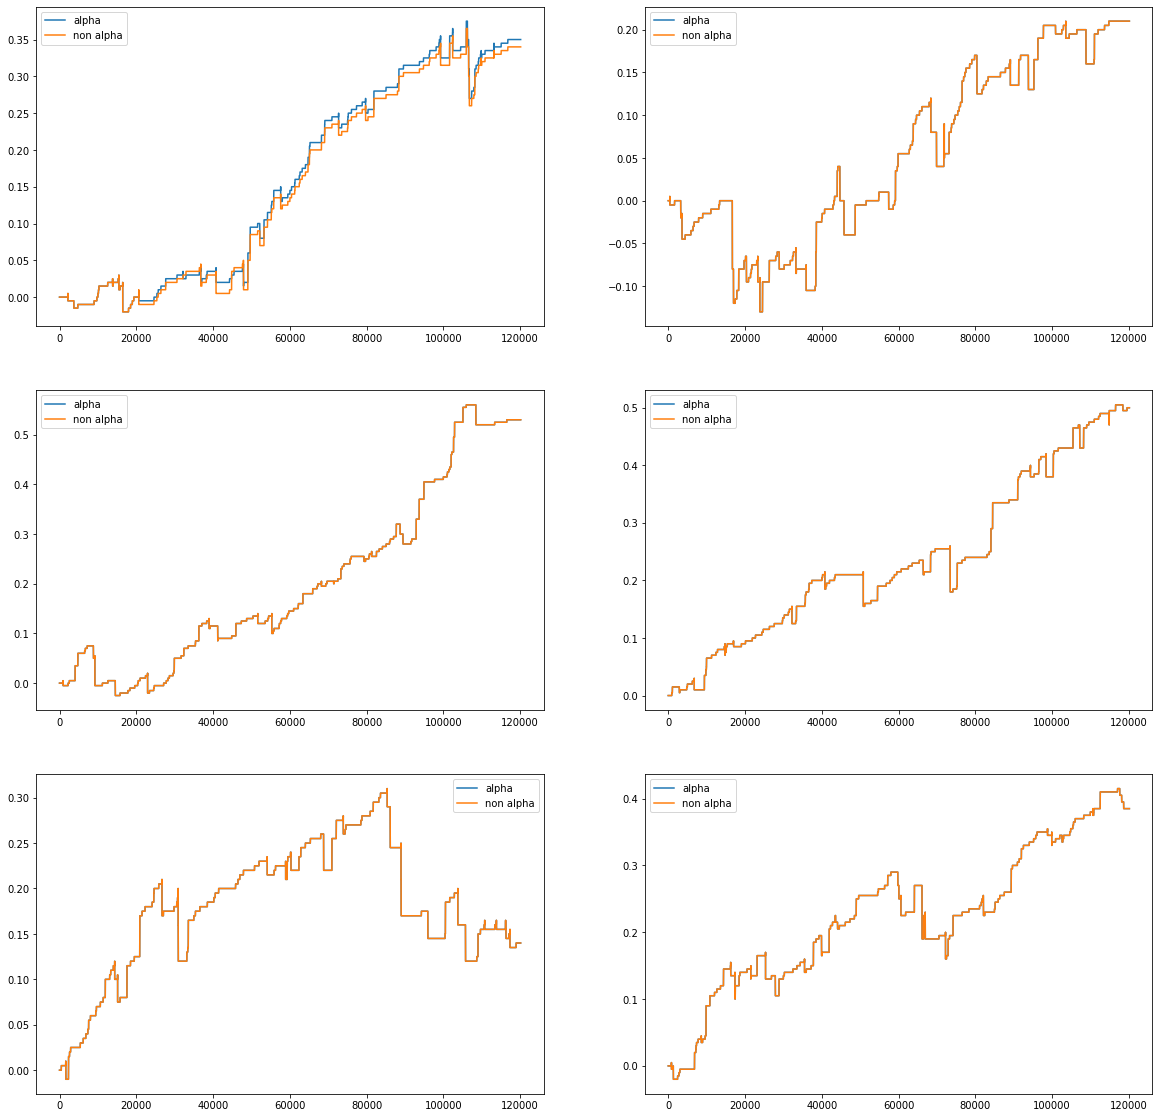

In [21]:
from matplotlib import pyplot as plt
fig, ((ax00, ax01), (ax10, ax11), (ax20, ax21)) = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for i, ax in enumerate([ax00, ax01, ax10, ax11,ax20,ax21]):
    ax.plot(alpha_pnl_200_6[i,:], label='alpha')
    ax.plot(non_alpha_pnl_200_6[i,:], label='non alpha')
    ax.legend()

### PNL histograms

alpha vs non alpha 1e-6

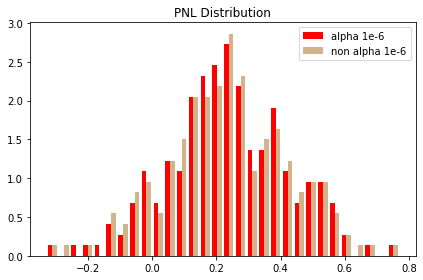

In [25]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 30
x =  np.array([alpha_pnl_200_6[:,-1], non_alpha_pnl_200_6[:,-1]]).transpose()

fig, ax = plt.subplots()

colors = ['red', 'tan']
labels = ['alpha 1e-6', 'non alpha 1e-6']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('PNL Distribution')

fig.tight_layout()
plt.show()

alpha vs non alpha 1e-3

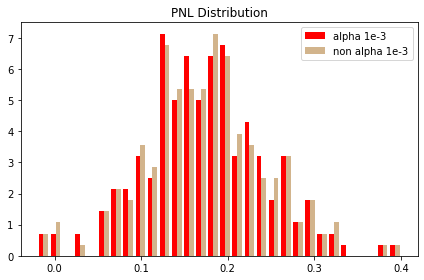

In [31]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 30
x =  np.array([alpha_pnl_200_3[:,-1], non_alpha_pnl_200_3[:,-1]]).transpose()

fig, ax = plt.subplots()

colors = ['red', 'tan']
labels = ['alpha 1e-3', 'non alpha 1e-3']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('PNL Distribution')

fig.tight_layout()
plt.show()

1e-6 vs 1e-3 alpha

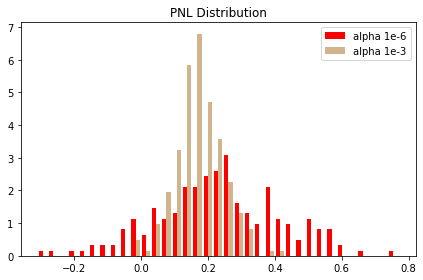

In [18]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 35
x =  np.array([alpha_pnl_200_6[:,-1], alpha_pnl_200_3[:,-1]]).transpose()

fig, ax = plt.subplots()

colors = ['red', 'tan']
labels = ['alpha 1e-6', 'alpha 1e-3']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('PNL Distribution')

fig.tight_layout()
plt.show()

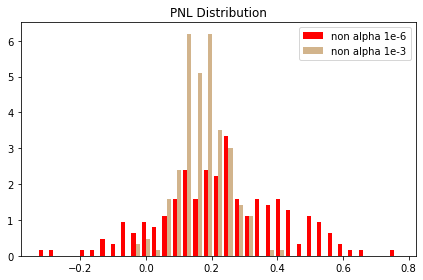

In [33]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 35
x =  np.array([non_alpha_pnl_200_6[:,-1], non_alpha_pnl_200_3[:,-1]]).transpose()

fig, ax = plt.subplots()

colors = ['red', 'tan']
labels = ['non alpha 1e-6', 'non alpha 1e-3']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('PNL Distribution')

fig.tight_layout()
plt.show()

## PNL vs stdev

In [33]:
pnls = [alpha_pnl_200_6[:,-1], non_alpha_pnl_200_6[:,-1]]

0.23452499999985632

In [36]:
mean_pnl = np.mean(pnls, axis=1)
print(mean_pnl)
stdev_pnl = np.std(pnls, axis=1)
print(stdev_pnl)

[0.234975 0.234075]
[0.18579929 0.18779316]


In [54]:
pnl_std = list(np.array([mean_pnl, stdev_pnl]).T)
pnl_std

[array([0.234975  , 0.18579929]), array([0.234075  , 0.18779316])]

Text(0, 0.5, 'pnl')

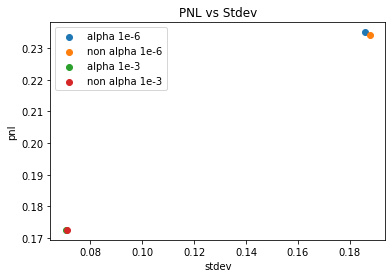

In [32]:

plt.scatter(np.std(alpha_pnl_200_6[:,-1]), np.mean(alpha_pnl_200_6[:,-1]), label='alpha 1e-6')
plt.scatter(np.std(non_alpha_pnl_200_6[:,-1]), np.mean(non_alpha_pnl_200_6[:,-1]), label='non alpha 1e-6')
plt.scatter(np.std(alpha_pnl_200_3[:,-1]), np.mean(alpha_pnl_200_3[:,-1]),  label='alpha 1e-3')
plt.scatter(np.std(non_alpha_pnl_200_3[:,-1]), np.mean(non_alpha_pnl_200_3[:,-1]), label='non alpha 1e-3')
plt.legend()
plt.title("PNL vs Stdev")
plt.xlabel("stdev")
plt.ylabel("pnl")

N=200
| Config   | PNL | StdDev |
|----------|-----|--------|
|1e-6 alpha|0.234975|0.18579929|
|1e-3 alpha|0.1726|0.07043|
|1e-6 non alpha|0.234075|0.18779316|
|1e-3 non alpha|0.172599|0.07080|

## Differences between simulation and paper

- granularity of alpha -> but should not make a difference for alpha=0
- amount of simulations
- in "short term alpha" the pnl is calculated using delta/2 =sigma= the price innovations. I use half the spread, not the total spread

Probably solved with new computer

Regarding difference in pnl:

_Note that for the large-tick stocks we study, the quoted spread is very often one tick, i.e, 2 Delta = 0,01, which is also
the size of the price innovations in our model._